### This is a Pytorch version of the work, for easier time working with ViT

# Step 1: Load and Preprocess the Dataset

### Load the GasVid dataset
### Preprocess the data
### Split the dataset into training and test sets

In [3]:
%%capture
%pip install --upgrade pip
%pip install -r ../requirements.txt

In [22]:
# if apple and want MPS acceleration do this
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.3 MB/s eta 0:00:0031m15.4 MB/s eta 0:00:01
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.7 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.3 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.6 MB/s eta 0:00:003.7 MB/s eta 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.9 MB/s eta 0:00:005.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.7 MB/s eta 0:00:003.7 MB/s eta 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.0 MB/s eta 0:00:00 MB/s eta 0:00:01:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01
I

In [79]:
# Imports

import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.notebook import tqdm
import pickle

from sklearn.metrics import RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, confusion_matrix

from sklearn.mixture import GaussianMixture


In [5]:
# Helper Functions

def calc_median(frames):
    median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
    return median_frame

def doMovingAverageBGS(image, prev_frames):
    median_img = calc_median(prev_frames)
    image = cv2.absdiff(image, median_img)
    return image

def calc_avg(frames):
  average_frame = np.mean(frames).astype(dtype=np.uint8)
  return average_frame

# Try Fixed background substraction
def doFixedBGS(image, init_frames):
  init_img = calc_avg(init_frames)
  image = cv2.absdiff(image, init_img)
  return image

# Try Mixture of Gaussian-Based (MOG) background substraction
def doMOGBGS(image, all_frames):
  gmm = GaussianMixture(n_components = 2)
  gmm_background = np.zeros(shape=(all_frames.shape[1:]))
  for i in range(all_frames.shape[1]):
      for j in range(all_frames.shape[2]):
          for k in range(all_frames.shape[3]):
              X = all_frames[:, i, j, k]
              X = X.reshape(X.shape[0], 1)
              gmm.fit(X)
              means = gmm.means_
              covars = gmm.covariances_
              weights = gmm.weights_
              idx = np.argmax(weights)
              gmm_background[i][j][k] = int(means[idx])
  image = cv2.absdiff(image, gmm_background)
  return image

In [6]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange, currCountLeak, currCountNonLeak):

  '''
  Input:
    String: pathIn should be the path of the video
    String: pathOut should be the path of the folder where data is being stored for testing or training
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")

  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isLeak, currCountLeak, currCountNonLeak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation

    '''
    #setting up moving average list
    prev_imgs = []
    prev_limit = 210 #210 in paper

    start = range[0] * 1000 # converting seconds to milliseconds
    end = range[1] * 1000
    cap = cv2.VideoCapture(pathIn)
    cap.set(cv2.CAP_PROP_POS_MSEC, start)
    success = True

    if cap.isOpened():
      while success and start < end:
          success, image = cap.read()
          image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

          start = cap.get(cv2.CAP_PROP_POS_MSEC)
          if success:

            prev_imgs.append(image)
            if len(prev_imgs) > prev_limit:
                prev_imgs.pop(0)

            processed_img = doMovingAverageBGS(image, prev_imgs) #to generalize might need to make this function as a parameter

            if isLeak:
                cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % currCountLeak), processed_img)     # save frame as JPEG file
                currCountLeak += 1
            else:
                cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % currCountNonLeak), processed_img)
                currCountNonLeak += 1
          else:
            break
      cap.release()
    cv2.destroyAllWindows()
    if isLeak:
       return currCountLeak
    else:
       return currCountNonLeak
  # call helper for both nonLeak and leak and get updated counts
  updated_currCountNonLeak = helper(pathIn, nonleakPath, nonleakRange, isLeak=False, currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)
  updated_currCountLeak = helper(pathIn, leakPath, leakRange, isLeak=True,currCountLeak=currCountLeak, currCountNonLeak=currCountNonLeak)

  return updated_currCountNonLeak, updated_currCountLeak

### Setting up Directories

In [7]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_movingAvg')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')


### Setting Up Ranges for Each Video In GasVid (Excluding 18.6m and 8.8m)

In [6]:
raw_data = np.loadtxt(os.path.join(dir_path, 'GasVid_Ranges_Seconds.csv'), skiprows=1, delimiter=',', dtype=int)

ranges = list(zip(raw_data[:, 0], raw_data[:, 1:3], raw_data[:, 3:5])) #need to upload new ranges
ranges = {ranges[i][0] : (ranges[i][1], ranges[i][2]) for i in range(len(ranges))}
len(ranges)

25

In [7]:
import re
def read_frames_from_dir(dir_path, output_path, max_vids=None):
    cur_count = 1
    currNonLeakCount = 0
    currLeakCount = 0

    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(re.findall("_(\d{4}).mp4",os.path.basename(vid_path))[0])
        # vid_id = int(os.path.basename(vid_path)[4:8])
        if vid_id not in ranges.keys():
            continue

        nonleak_start = ranges[vid_id][0][0]
        nonleak_end = ranges[vid_id][0][1]
        leak_start = ranges[vid_id][1][0]
        leak_end = ranges[vid_id][1][1]

        currNonLeakCount, currLeakCount = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end), currLeakCount, currNonLeakCount)
        print("Video", vid_id)
        print("Current NonLeak Count", currNonLeakCount)
        print("Current Leak Count", currLeakCount)

        print('Done with', cur_count, "video(s)")
        cur_count += 1
    return currNonLeakCount, currLeakCount

### Reading Frames from Data Directory and Setting Them in Frame Data Directory

In [8]:
image_dim = (240, 320)
vid_count = 4 # Smaller on local computer to limit computer resources #max =>15

test_count = 2 #Smaller on local computer to limit computer resources #max =>10
total_train_NonLeak, total_train_Leak = read_frames_from_dir(train_data_dir, frame_train_data_dir, vid_count)
print("Done with Training Data")
total_test_NonLeak, total_test_Leak = read_frames_from_dir(test_data_dir, frame_test_data_dir, test_count)
print("Done with Testing Data")

Video 2570
Current NonLeak Count 2386
Current Leak Count 18475
Done with 1 video(s)
Video 2564
Current NonLeak Count 4774
Current Leak Count 36946
Done with 2 video(s)
Video 2559
Current NonLeak Count 7160
Current Leak Count 55410
Done with 3 video(s)
Video 2567
Current NonLeak Count 9545
Current Leak Count 73896
Done with 4 video(s)
Done with Training Data
Video 1469
Current NonLeak Count 2384
Current Leak Count 18485
Done with 1 video(s)
Video 1468
Current NonLeak Count 4771
Current Leak Count 36972
Done with 2 video(s)
Done with Testing Data


In [12]:
print("Total NonLeak Count", total_train_NonLeak + total_test_NonLeak)
print("Total Leak Count", total_train_Leak + total_test_Leak)

Total NonLeak Count 14316
Total Leak Count 110868


# Step 2: Create Dataset for Ingesting Image Frames

In [66]:
class MultiClassVideoFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None, processor=None):
        self.root_dir = root_dir
        self.transform = transform
        self.processor = processor
        self.classes = os.listdir(root_dir)  # Get class names from subdirectories

        self.frames = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            frame_list = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]
            self.frames.extend(frame_list)
            self.labels.extend([class_idx] * len(frame_list))

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_path = self.frames[idx]
        image = cv2.imread(frame_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        if self.transform:
            image = self.transform(image)
        
        if self.processor:
            image = self.processor.preprocess(image, return_tensors="pt")

        label = self.labels[idx]

        return image, label

In [60]:
image_processor = ViTImageProcessor(
    "google/vit-base-patch16-224",
    do_normalize=True,
    max_size=384,
    pad_to_max_size=True
)

In [13]:
# define some transforms
transform = transforms.Compose([
])

In [67]:
full_train_dataset = MultiClassVideoFrameDataset(root_dir=frame_train_data_dir, transform=transform, processor=image_processor)
test_dataset = MultiClassVideoFrameDataset(root_dir=frame_test_data_dir, transform=transform, processor=image_processor)

# Define the percentage of data to use for validation
validation_split = 0.2  # Adjust this as needed

# Calculate the number of samples for the validation set
num_samples = len(full_train_dataset)
num_val_samples = int(validation_split * num_samples)
num_train_samples = num_samples - num_val_samples

# Create a list of indices for the full dataset
indices = list(range(num_samples))

# Use random sampling to split the indices into train and validation indices
val_indices = torch.randperm(num_samples)[:num_val_samples]
train_indices = list(set(indices) - set(val_indices))

# Create Subset objects for train and validation
train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(train_dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Step 3: Build the GasViT Architecture

### Define the GasNet architecture (GasNet-2 as mentioned in the paper)
### Implement the model using TensorFlow/Keras

In [40]:
device = torch.device('mps')
device
# model.to(device)

device(type='mps')

In [61]:
# Initialize the ViT feature extractor and model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [62]:
# Change classifier layer to have num classes consistent with dataset
model.classifier.out_features = len(full_train_dataset.classes)
model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [63]:
train_dataloader.dataset.dataset.classes

['Leak', 'Nonleaks']

In [82]:
def train(model, num_epochs=10):
    criterion = nn.CrossEntropyLoss() # extendable for multiclass classification as well
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # can try out lr scheduler later if needed
    # can also try out warmup ratio

    for epoch in range(num_epochs):
        model.train()
        for batch_images, batch_labels in tqdm(train_dataloader):
            batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_image_pixels).logits
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

        model.eval()
        accuracy = 0
        total_samples = 0

        with torch.no_grad():
            for batch_images, batch_labels in tqdm(val_dataloader, leave=False):
                batch_image_pixels, batch_labels = batch_images.pixel_values.squeeze(1).to(device), batch_labels.to(device)
                outputs = model(batch_image_pixels).logits
                _, predicted = torch.max(outputs, 1)
                accuracy += (predicted == batch_labels).sum().item()
                total_samples += batch_labels.size(0)

        validation_accuracy = accuracy / total_samples
        print(f"Validation Accuracy: {validation_accuracy:.4f}")


In [83]:
train(model, 2)

  0%|          | 0/2608 [00:00<?, ?it/s]

torch.Size([32, 1, 3, 224, 224]) torch.Size([32])
torch.Size([32, 1, 3, 224, 224]) torch.Size([32])


KeyboardInterrupt: 

### Setting up Generator for Training, Validation, and Testing

In [14]:
val_split = 0.2
batch_size = 32
target_size = (240, 320)


train_datagen = ImageDataGenerator(
    # featurewise_center=True, #cant do this as need entire dataset to do it | need to figure out a way in doing this
    # featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
)

train_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

val_generator = train_datagen.flow_from_directory(
    directory=frame_train_data_dir,
    class_mode="binary",
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)


test_datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_generator = test_datagen.flow_from_directory(
    directory=frame_test_data_dir,
    class_mode='binary',
    batch_size=batch_size,
    color_mode="grayscale",
    target_size=target_size,
    classes=["Nonleaks", "Leak"]

)

Found 66753 images belonging to 2 classes.
Found 16688 images belonging to 2 classes.
Found 41743 images belonging to 2 classes.


### Adjust classweights to account for class imbalance

In [15]:
# Adjust Class weights here
class_weight = {0: 8, 1: 1}

### Data Visualization (Confusion Matrix and ROC Curves)

In [16]:
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, num_batches, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.num_batches = num_batches

        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        batch_num = 0
        for data, true_label in self.validation_data:
            batch_pred = self.model.predict(data, verbose=0)
            y_pred.append(batch_pred)
            y_true.append(true_label)

            if batch_num >= self.num_batches:
                break
            batch_num += 1

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        threshold = 0.5
        y_pred = (y_pred > threshold).astype(int)


        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        cm = confusion_matrix(y_true, y_pred)
        # cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax, name=f"Confusion Matrix of Validation Data at Epoch {epoch}")
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
        ax.set_title(f"Confusion Matrix of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

        # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        # roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, name=f"ROC Curve of Validation Data at Epoch {epoch}")
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
        ax.set_title(f"ROC Curve of Validation Data at Epoch {epoch}")
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

performance_cbk = PerformanceVisualizationCallback(
                      model=model,
                      validation_data=val_generator,
                      num_batches=len(val_generator),
                      image_dir='performance_vizualizations')

# Step 3: Train the GasNet Model

### Set hyperparameters (learning rate, batch size, etc.)
### Train the model using the training data
### Use the validation data for hyperparameter tuning and monitoring performance

In [18]:
# Evaluation Metrics

def F1Score(y_true, y_pred):
    threshold = 0.5
    y_pred = tf.where(y_pred >= threshold, 1.0, 0.0)

    prec = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()

    prec.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)

    prec_res = prec.result()
    rec_res = recall.result()

    return tf.where(tf.math.add(prec_res, rec_res) > 0,
                    2 * (prec_res * rec_res) / (prec_res + rec_res),
                    0.0)


# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy',  metrics=[F1Score, "acc"], run_eagerly=True)


Epoch 1/10


2023-10-06 09:29:46.502054: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2086/2086 [==============================] - 756s 362ms/step - loss: 0.0503 - F1Score: 0.9890 - acc: 0.9810 - val_loss: 0.5346 - val_F1Score: 0.9517 - val_acc: 0.9133
Epoch 2/10
2086/2086 [==============================] - 813s 390ms/step - loss: 0.0102 - F1Score: 0.9980 - acc: 0.9966 - val_loss: 0.2237 - val_F1Score: 0.9745 - val_acc: 0.9552
Epoch 3/10
 130/2086 [>.............................] - ETA: 11:20 - loss: 0.0083 - F1Score: 0.9987 - acc: 0.9978

KeyboardInterrupt: 

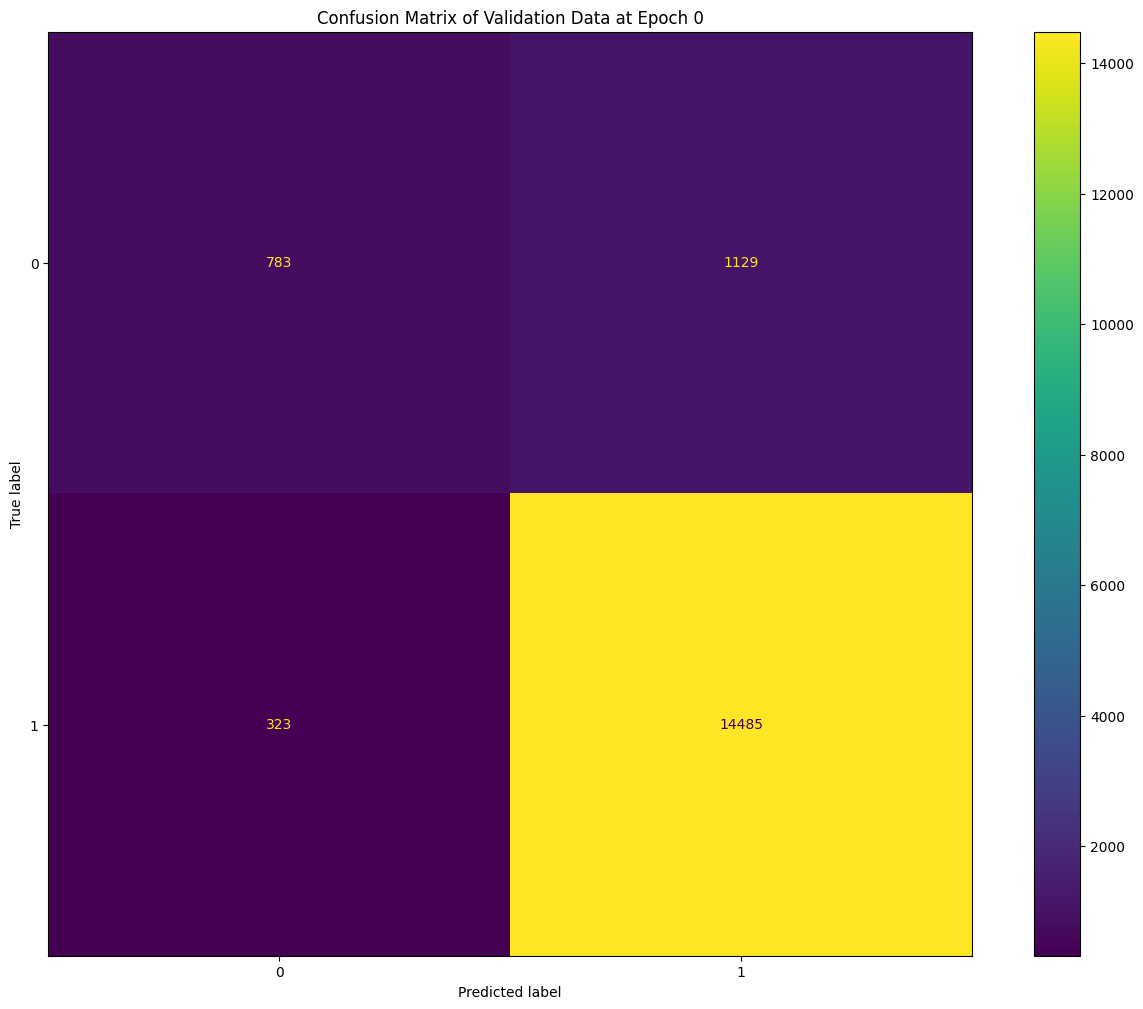

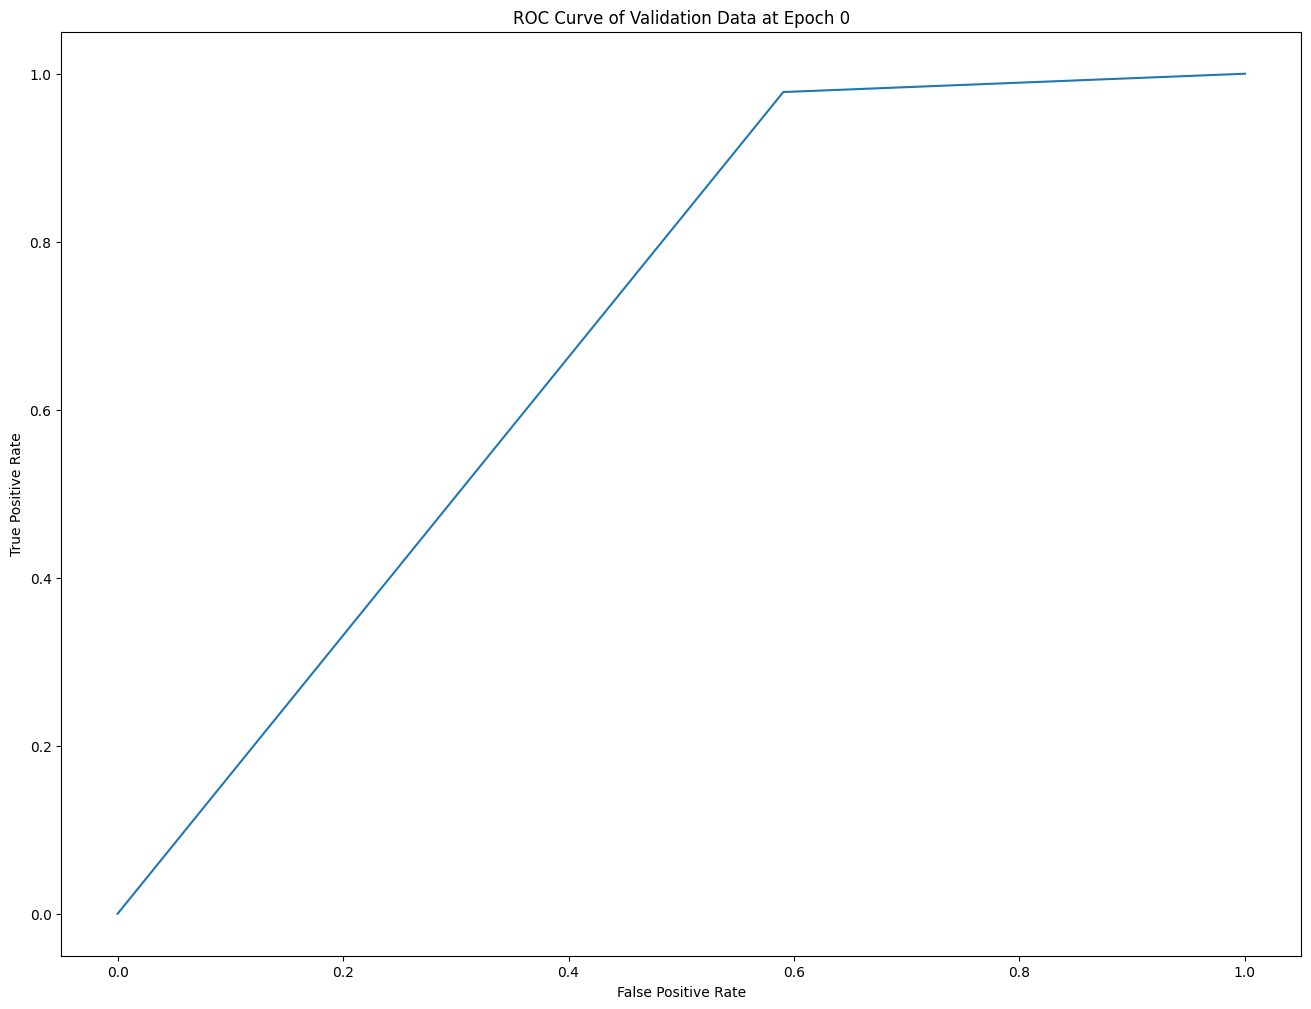

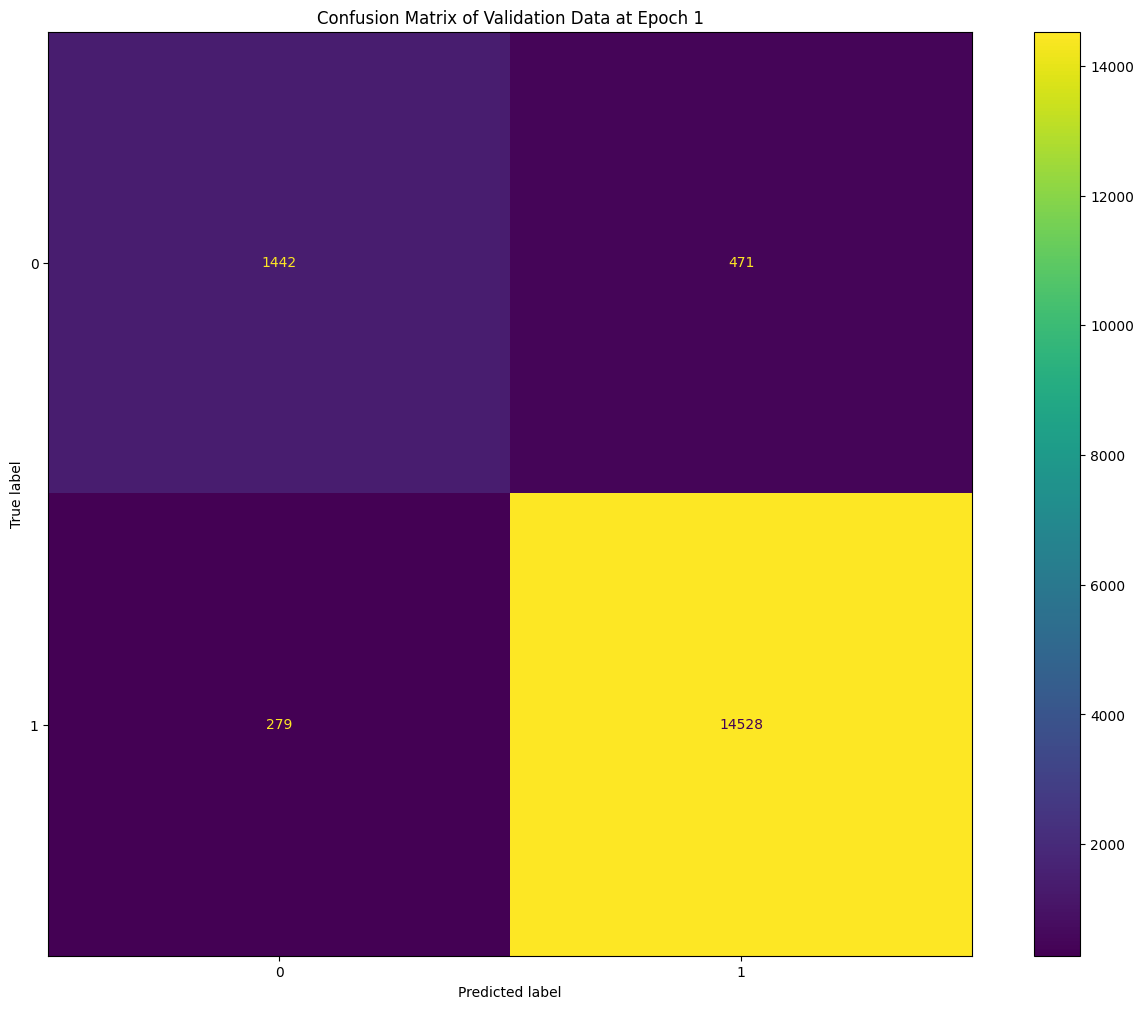

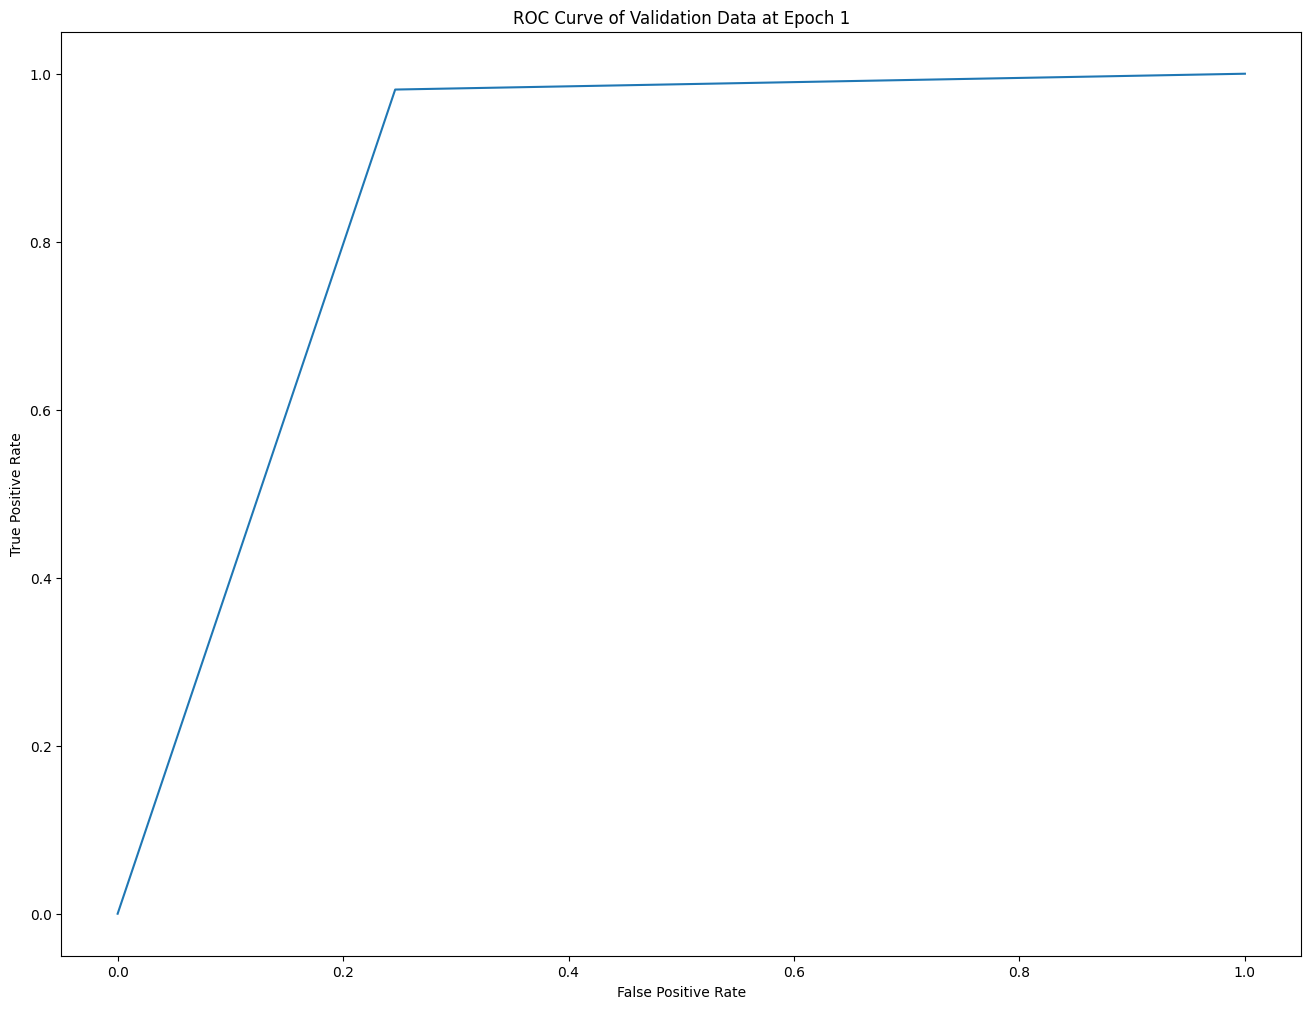

In [19]:
class SaveHistory(Callback):
    def __init__(self, filepath):
        super(SaveHistory, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filepath, 'wb') as file:
            pickle.dump(self.model.history.history, file)

# Create an instance of the custom callback
save_history_callback = SaveHistory('training_history.pkl')

num_epochs = 10

history = model.fit(
    x = train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = num_epochs,
    callbacks=[performance_cbk, save_history_callback] #uncomment once you want to use it
)

# Step 4: Evaluate the model on the Test Dataset

### Generate evaluation metrics and plots such as confusion matrix and ROC curves, F1 score, etc.

We are primarily concerned with high false positive rate due to the extreme class imbalance

In [22]:
predictions = model.predict(test_generator)

1305/1305 [==============================] - 83s 63ms/step


In [23]:
ground_truth_labels = test_generator.classes

In [51]:
threshold = 0.7
processed_preds = (predictions >= threshold).flatten().astype(int)

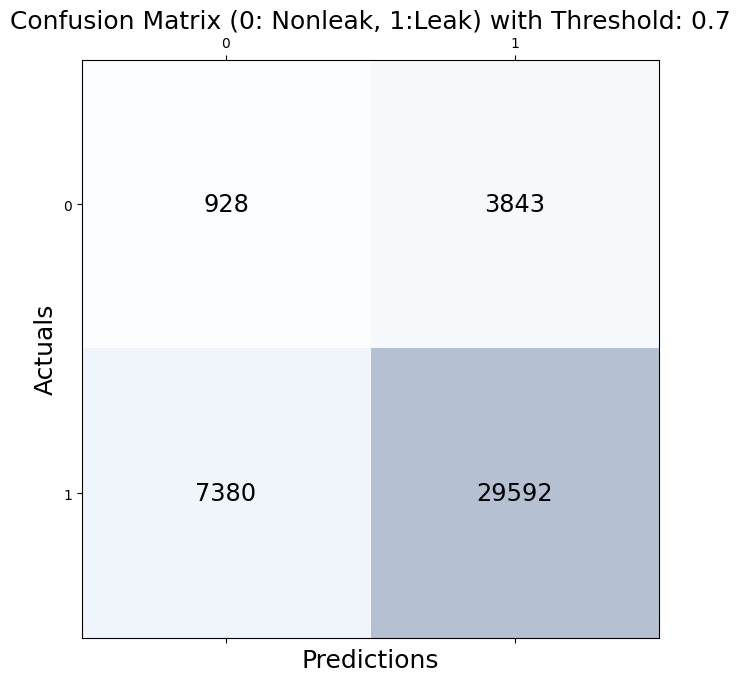

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#source: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/

conf_matrix = confusion_matrix(y_true=ground_truth_labels.astype(int), y_pred=processed_preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Confusion Matrix (0: Nonleak, 1:Leak) with Threshold: {threshold}', fontsize=18)
plt.show()

In [58]:
from sklearn.metrics import accuracy_score,f1_score
predicted_labels = predictions.argmax(axis=1)  # Convert predicted probabilities to class labels
accuracy = accuracy_score(ground_truth_labels, processed_preds)

In [54]:
accuracy

0.731140550511463

In [59]:
f1 = f1_score(ground_truth_labels, processed_preds)
f1

0.8405982359708553

In [55]:
conf_matrix = confusion_matrix(ground_truth_labels, processed_preds)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

In [56]:
for label, acc in zip(['Nonleak', 'Leak'], per_class_accuracy):
    print(f"Class '{label}' Accuracy: {acc:.2f}")

Class 'Nonleak' Accuracy: 0.19
Class 'Leak' Accuracy: 0.80
